In [1]:
!pip install textacy
!python -m spacy download de_core_news_lg

✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_lg')


In [2]:
import sys, os
ON_COLAB = 'google.colab' in sys.modules

if ON_COLAB:
    os.system("test -f heise-articles-2020.db || wget  https://datanizing.com/heiseacademy/nlp-course/blob/main/99_Common/heise-articles-2020.db.gz && gunzip heise-articles-2020.db.gz")
    newsticker_db = 'heise-articles-2020.db'
else:
    newsticker_db = '../99_Common/heise-articles-2020.db'

In [3]:
import sqlite3 
import pandas as pd

sql = sqlite3.connect(newsticker_db)
df = pd.read_sql("SELECT * FROM nlp_articles \
                   WHERE datePublished<'2021-01-01' \
                   ORDER BY datePublished", sql, index_col="id", parse_dates=["datePublished"])

<AxesSubplot:ylabel='Frequency'>

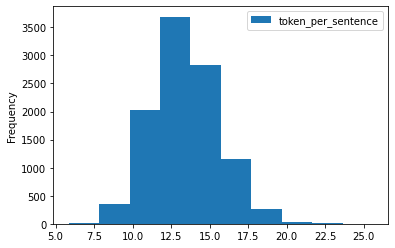

In [4]:
df["token_per_sentence"] = df["no_tokens"] / df["no_sentences"]
df[["token_per_sentence"]].plot.hist()

In [5]:
import spacy
nlp = spacy.load("de_core_news_lg")

In [8]:
import textacy.text_stats
from tqdm.auto import tqdm

df["fulltext"] = df["title"] + "\n" + df["header"] + "\n" + df["text"]
for i, r in tqdm(df.iterrows(), total=len(df)):
    tdoc = textacy.make_spacy_doc(r["fulltext"], lang="de_core_news_lg")
    ts = textacy.text_stats.TextStats(tdoc)
    df.at[i, "entropy"] = ts.entropy
    df.at[i, "coleman_liau_index"] = ts.coleman_liau_index
    df.at[i, "gunning_fog_index"] = ts.gunning_fog_index
    df.at[i, "flesch_kincaid_grade_level"] = ts.flesch_kincaid_grade_level
    df.at[i, "smog_index"] = ts.smog_index
    df.at[i, "wiener_sachtextformel"] = ts.wiener_sachtextformel

  0%|          | 0/10403 [00:00<?, ?it/s]

In [ ]:
df[["entropy"]].plot.hist()

In [ ]:
df[["coleman_liau_index"]].plot.hist()

In [ ]:
df[["smog_index"]].plot.hist()

In [ ]:
df[["flesch_kincaid_grade_level"]].plot.hist()

In [ ]:
df[["wiener_sachtextformel"]].plot.hist()

In [ ]:
top_authors = df.groupby("author").agg({"url": "count"}).sort_values("url").tail(20).index.values
top_author_articles = df[df["author"].isin(top_authors)]

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 10))
labels = top_author_articles.groupby("author").agg({"wiener_sachtextformel": "median"}).sort_values("wiener_sachtextformel").index.values
sns.violinplot(y="author", x="wiener_sachtextformel", data=top_author_articles, order=labels, palette="viridis")

In [ ]:
pd.set_option("display.max_colwidth", None)
df.sort_values("wiener_sachtextformel").tail(10)[["author", "title", "url"]]